## Restructuring the Financial Stress Index (OFR FSI)
### Name: Sahil Khaja Huzoor (AMS-QF) and Siam Miah (AMS-QF)


### - Quick Recap on our last presentation

#### Worked on a whole new dataset due to issues with the previous data set. Now we will regress only on different index datas
#### New Factors:
1. DAX (German)
2. DJI (United States)
3. FTSE (United Kingdom)
4. HSI (Hong Kong)
5. IXIC (United States)
6. N225 (Japan)
7. SPX (United States)
8. VIX (United States, CBOE)

In [64]:
import pandas as pd
import glob
from statsmodels.tsa.stattools import adfuller
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.stattools import kpss
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import SimpleRNN, Dense
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from sklearn.model_selection import train_test_split
# import numpy as np
# import keras_tuner

### LOAD DATA

In [37]:
files = glob.glob(r"C:\projects\ams520\Data\*.csv")#glob the files we are working with

list_of_dfs = [] #instantiate an empty list to append dataframe into it later
for file in files:
    try:
        if "fsi" not in file:
            loc_of_paren = file.split("\\")[-1].find("(") #where the parenthesis is
            indicator = file.split("\\")[-1][:loc_of_paren].strip() #the name of the indicator minus space
            temp = pd.read_csv(file)
            temp.rename(columns = {"Close":indicator},inplace=True) #rename CLose to indicator name
            temp = temp[["Date", indicator]] #Date and indicator column
            temp.Date = pd.to_datetime(temp.Date).dt.date #get date from date time
            temp.set_index("Date",inplace=True) #set it to index
            list_of_dfs.append(temp)
            # list_of_dfs[indicator] = temp #append the values
        else:
            temp = pd.read_csv(file)
            temp['Date'] = pd.to_datetime(temp['Date'])
            temp.set_index("Date", inplace=True)
            # list_of_dfs["FSI"] = temp[["OFR FSI"]]
            list_of_dfs.append(temp[["OFR FSI"]])
    except Exception as e:
        print(e.__str__())
        print(file)

### MERGE AND CLEANUP DATA

In [38]:
#Merge
dfs= list_of_dfs[0]
for i in range(1, len(list_of_dfs)):
    # print(list_of_dfs[i].columns)
    dfs = dfs.merge(list_of_dfs[i], right_index=True, left_index=True, how="inner")

#Convert to float whenever we spot an object data type
for col in dfs.columns:
    if str(dfs[col].dtype) == "object":
        dfs[col] = dfs[col].str.replace(",","")
        dfs[col] = dfs[col].astype("float")

dfs.columns = [x.replace("Data/","").replace(".cs","") for x in dfs.columns]


In [39]:
dfs.sample(5)

,DAX,DJI,OFR FSI,FTSE,HSI,IXIC,N225,SPX,VIX
Date,,,,,,,,,
2019-05-20,12011.00,25586.0,-2.346,7277.73,27354.0,7637.01,21117.0,2826.06,15.85
2024-05-20,18693.00,39070.0,-2.376,8317.59,18609.0,16921.00,38646.0,5304.72,11.93
2016-03-28,9794.64,17793.0,0.118,6146.05,20499.0,4914.54,16164.0,2072.78,13.10
2017-01-23,11814.00,20094.0,-1.871,7184.49,23361.0,5660.78,19467.0,2294.69,10.58
2021-03-29,15107.00,33153.0,-3.466,6737.30,28939.0,13480.00,29854.0,4019.87,17.33


### LETS VISUALIZE THE DATA

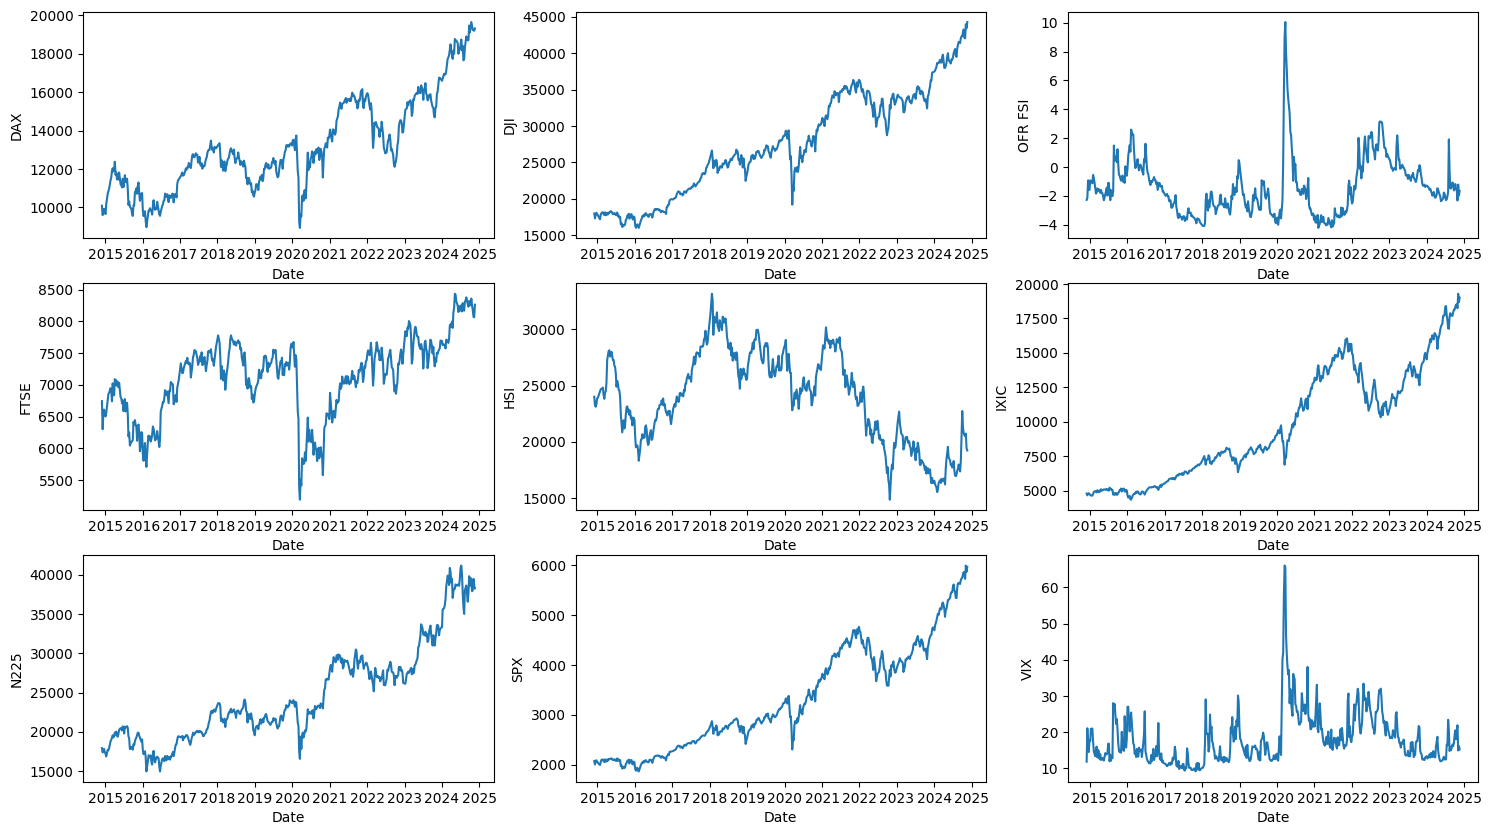

In [40]:
fig, axes = plt.subplots(nrows = 3, ncols=3,figsize=(18, 10))
i  = 0; j=0
for col in dfs.columns:
    sns.lineplot(ax=axes[i, j], x = dfs.index, y=dfs[col])
    j+=1
    if j > 2:
        j = 0
        i+=1
    else:
        pass

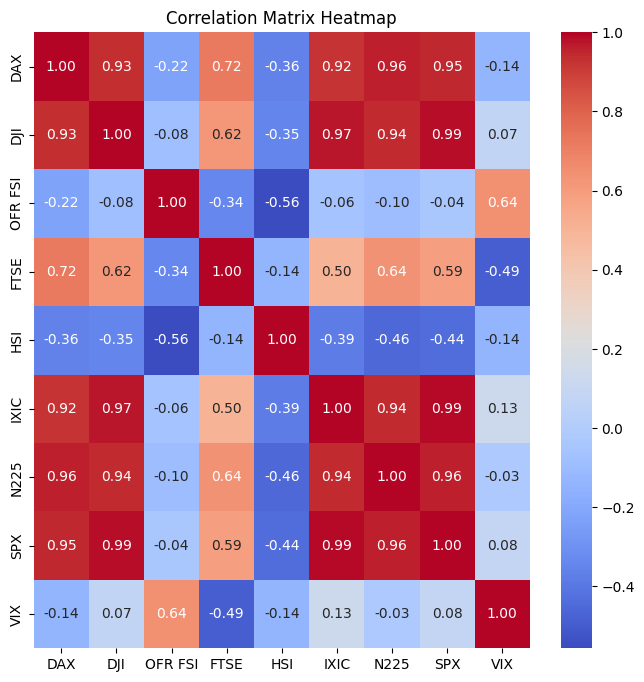

In [145]:
plt.figure(figsize=(8, 8))
sns.heatmap(dfs.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

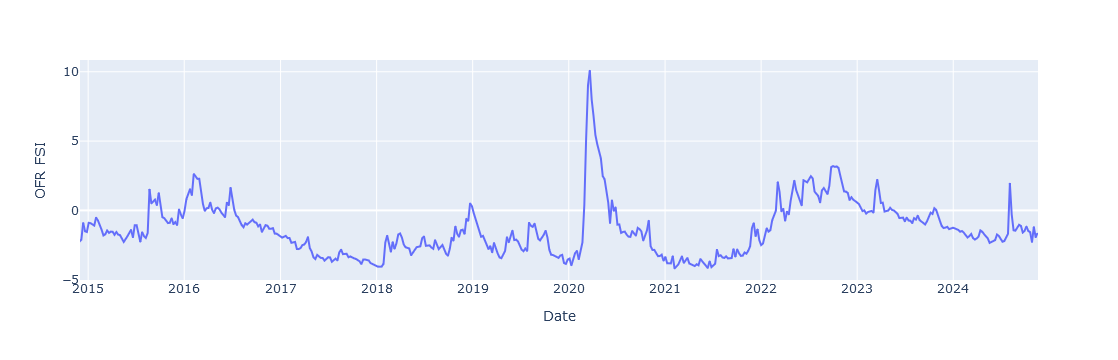

In [31]:
px.line(dfs, x=dfs.index, y="OFR FSI")

## MODELLING
### Performance metric: MSE
### Test/Train Split
 - Training the models on data upto and including 2022-12-12 ~ 81%
 - Test will on data from 2023-01-09 to 2024-11-18

### Linear Regression - Benchmark Model

In [41]:
comparison_df = dfs[['OFR FSI']]

In [42]:
y_train, x_train = dfs.loc[:"2023-01-01", ['OFR FSI']], dfs.loc[:"2023-01-01"].drop(columns = ['OFR FSI'])
y_test,  x_test  = dfs.loc["2023-01-01":, ['OFR FSI']], dfs.loc["2023-01-01":].drop(columns = ['OFR FSI'])

In [44]:
lr_model = LinearRegression() #Instantiate the model
lr_model.fit(x_train,y_train) #fit and train the model
in_sample_prediction = lr_model.predict(x_train)
in_sample_prediction = pd.Series([x[0] for x in in_sample_prediction], index = y_train.index)
out_sample_prediction = lr_model.predict(x_test)
out_sample_prediction = pd.Series([x[0] for x in out_sample_prediction], index = y_test.index)
cor_coef =  np.corrcoef(y_test["OFR FSI"], out_sample_prediction)[0,1] ##correlation coefficient

print("In  sample score R^2  : ", lr_model.score(x_train,y_train) )
print("Out sample Correlation: ", cor_coef )
print("Out sample MSE        : ", mean_squared_error(y_test, out_sample_prediction) )
comparison_df.loc[:,'LR_Estimate'] = pd.concat([in_sample_prediction,out_sample_prediction], axis=0)

In  sample score R^2  :  0.8167912953418857
Out sample Correlation:  0.5892959373960338
Out sample MSE        :  0.9633295629197722


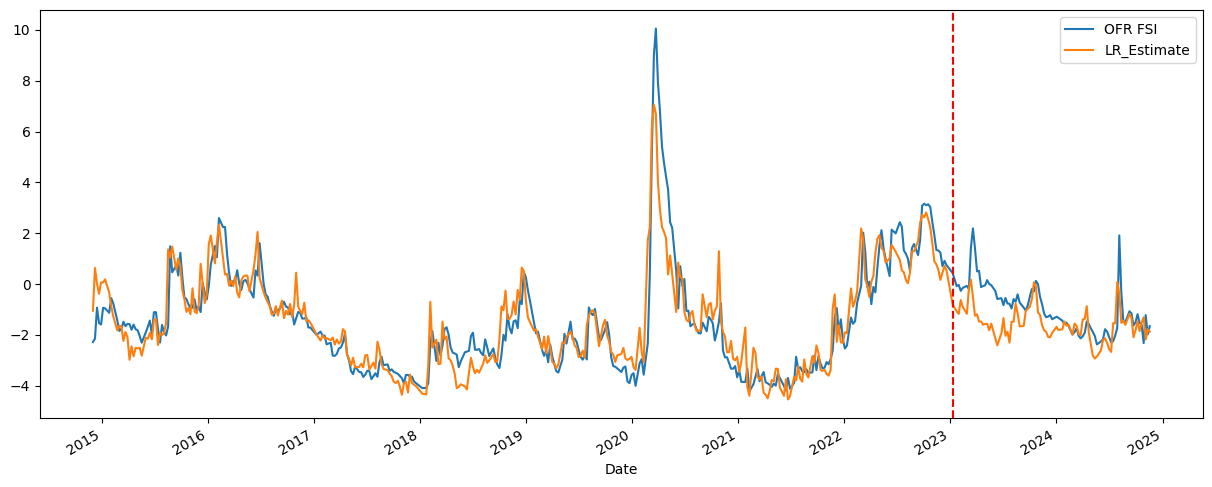

In [49]:
comparison_df[['OFR FSI', 'LR_Estimate']].plot(figsize = (15,6)).axvline(x="2023-01-09", color='red', linestyle='--')


### Light GBM

In [51]:
lgm_model = LGBMRegressor(num_leaves=5,max_depth = 1,n_estimators=1000) #Instantiate the model
lgm_model.fit(x_train,y_train) #fit and train the model
in_sample_prediction = lgm_model.predict(x_train)
in_sample_prediction = pd.Series([x for x in in_sample_prediction], index = y_train.index)
out_sample_prediction = lgm_model.predict(x_test)
out_sample_prediction = pd.Series([x for x in out_sample_prediction], index = y_test.index)
cor_coef =  np.corrcoef(y_test["OFR FSI"], out_sample_prediction)[0,1] ##correlation coefficient

print("In  sample score R^2  : ", lgm_model.score(x_train,y_train) )
print("Out sample Correlation: ", cor_coef )
print("Out sample MSE        : ", mean_squared_error(y_test, out_sample_prediction) )
comparison_df.loc[:,'LGBM_Estimate'] = pd.concat([in_sample_prediction,out_sample_prediction], axis=0)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 380, number of used features: 8
[LightGBM] [Info] Start training from score -1.479348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\sahil\AppData\Local\Temp\ipykernel_9396\4278358596.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df.loc[:,'LGBM_Estimate'] = pd.concat([in_sample_prediction,out_sample_prediction], axis=0)


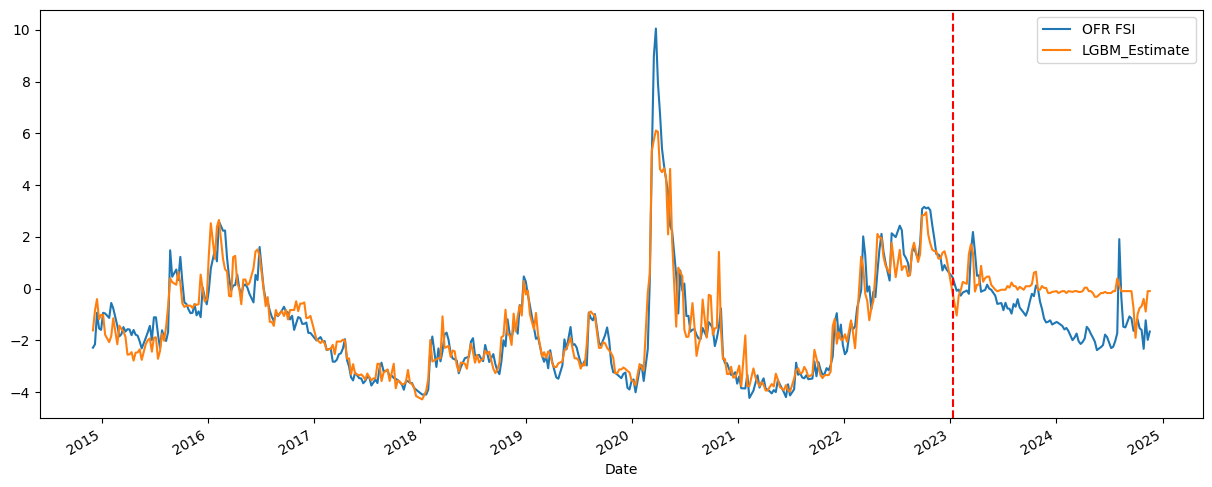

In [53]:
comparison_df[['OFR FSI', 'LGBM_Estimate']].plot(figsize = (15,6)).axvline(x="2023-01-09", color='red', linestyle='--')

## Random Forrest

In [54]:
rf_model = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=500,max_features=2,max_leaf_nodes=30) #Instantiate the model
rf_model.fit(x_train,y_train) #fit and train the model
in_sample_prediction = rf_model.predict(x_train)
in_sample_prediction = pd.Series([x for x in in_sample_prediction], index = y_train.index)
out_sample_prediction = rf_model.predict(x_test)
out_sample_prediction = pd.Series([x for x in out_sample_prediction], index = y_test.index)
cor_coef =  np.corrcoef(y_test["OFR FSI"], out_sample_prediction)[0,1] ##correlation coefficient

print("In  sample score R^2  : ", rf_model.score(x_train, y_train) )
print("Out sample Correlation: ", cor_coef )
print("Out sample MSE        : ", mean_squared_error(y_test, out_sample_prediction) )
comparison_df.loc[:,'RF_Estimate'] = pd.concat([in_sample_prediction, out_sample_prediction], axis=0)

C:\projects\ams520\venv\lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In  sample score R^2  :  0.667460288138933
Out sample Correlation:  0.5186772861065269
Out sample MSE        :  0.8229708638487628


C:\Users\sahil\AppData\Local\Temp\ipykernel_9396\1379283636.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df.loc[:,'RF_Estimate'] = pd.concat([in_sample_prediction, out_sample_prediction], axis=0)


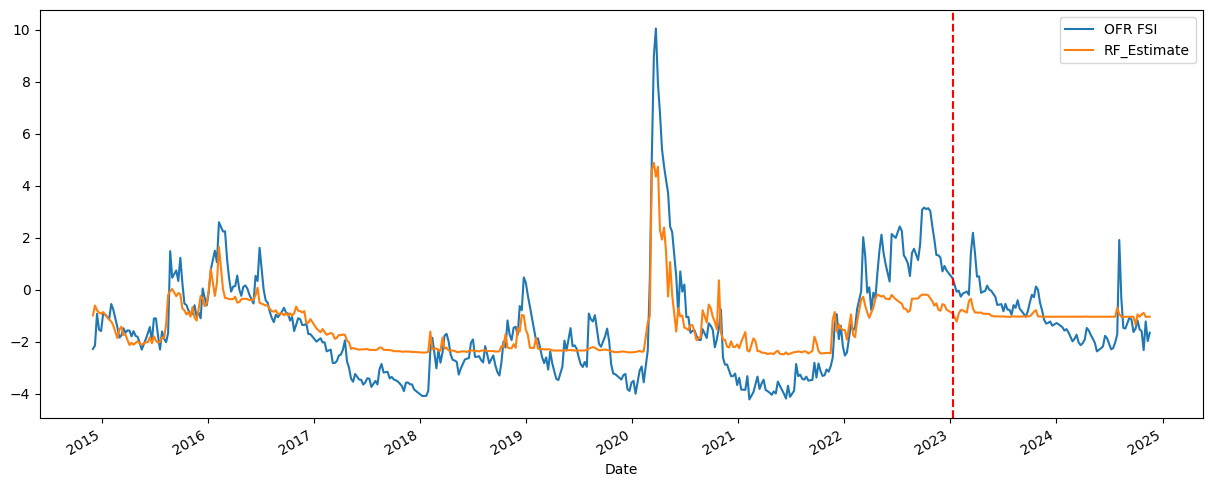

In [56]:
comparison_df[['OFR FSI', 'RF_Estimate']].plot(figsize = (15,6)).axvline(x="2023-01-09", color='red', linestyle='--')

### Polynomial Regression

In [57]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features_train = poly.fit_transform(x_train)
poly_features_test = poly.fit_transform(x_test)

poly_model = LinearRegression() #Instantiate the model
poly_model.fit(poly_features_train, y_train) #fit and train the model
in_sample_prediction = poly_model.predict(poly_features_train)
in_sample_prediction = pd.Series([x[0] for x in in_sample_prediction], index = y_train.index)

out_sample_prediction = poly_model.predict(poly_features_test)
out_sample_prediction = pd.Series([x[0] for x in out_sample_prediction], index = y_test.index)
cor_coef =  np.corrcoef(y_test["OFR FSI"], out_sample_prediction)[0,1] ##correlation coefficient

print("In  sample score R^2  : ", poly_model.score(poly_features_train, y_train) )
print("Out sample Correlation: ", cor_coef )
print("Out sample MSE        : ", mean_squared_error(y_test, out_sample_prediction) )
comparison_df.loc[:,'Poly_Estimate'] = pd.concat([in_sample_prediction,out_sample_prediction], axis=0)

In  sample score R^2  :  0.8964242325447006
Out sample Correlation:  -0.5970652614311187
Out sample MSE        :  26.73056544227023


C:\Users\sahil\AppData\Local\Temp\ipykernel_9396\3242349948.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df.loc[:,'Poly_Estimate'] = pd.concat([in_sample_prediction,out_sample_prediction], axis=0)


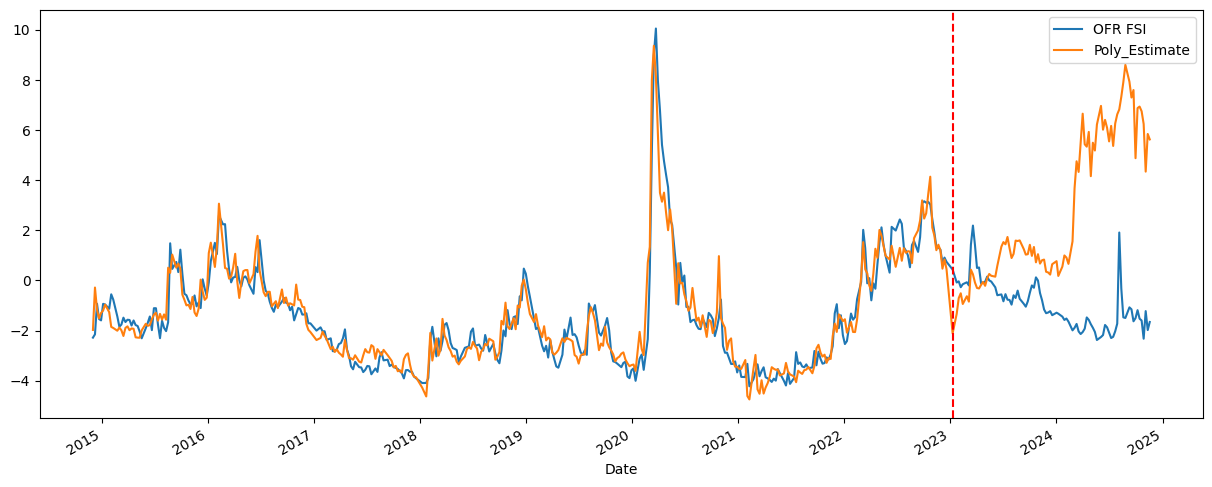

In [58]:
comparison_df[['OFR FSI', 'Poly_Estimate']].plot(figsize = (15,6)).axvline(x="2023-01-09", color='red', linestyle='--')

### AR-X Model

In [59]:
## Arrange Train
arx_train_data = pd.concat([y_train, y_train.shift(1).rename(columns = {"OFR FSI": "OFR FSI Lag"}), x_train.shift(1)], axis=1)
arx_train_data = arx_train_data.dropna()
arx_y_train, arx_x_train = arx_train_data[['OFR FSI']], arx_train_data.drop(columns = ['OFR FSI'])

##Arrange Test
arx_test_data = pd.concat([y_test, y_test.shift(1).rename(columns = {"OFR FSI": "OFR FSI Lag"}), x_test.shift(1)], axis=1)
arx_test_data.iloc[0,1:] = y_train.tail(1).values.tolist()[0] + x_train.tail(1).values.tolist()[0] #Borrow from previous row because lag1
arx_y_test, arx_x_test = arx_test_data[['OFR FSI']], arx_test_data.drop(columns = ['OFR FSI'])

arx_model = LinearRegression() #Instantiate the model
arx_model.fit(arx_x_train, arx_y_train) #fit and train the model
in_sample_prediction = arx_model.predict(arx_x_train)
in_sample_prediction = pd.Series([x[0] for x in in_sample_prediction], index = arx_y_train.index)

out_sample_prediction = arx_model.predict(arx_x_test)
out_sample_prediction = pd.Series([x[0] for x in out_sample_prediction], index = arx_y_test.index)
cor_coef =  np.corrcoef(arx_y_test["OFR FSI"], out_sample_prediction)[0,1] ##correlation coefficient

print("In  sample score R^2  : ", arx_model.score(arx_x_train, arx_y_train) )
print("Out sample Correlation: ", cor_coef )
print("Out sample MSE        : ", mean_squared_error(arx_y_test, out_sample_prediction) )
comparison_df.loc[:,'ARX_Estimate'] = pd.concat([in_sample_prediction,out_sample_prediction], axis=0)

In  sample score R^2  :  0.9520736547806783
Out sample Correlation:  0.810068997314815
Out sample MSE        :  0.3867870817644205


C:\Users\sahil\AppData\Local\Temp\ipykernel_9396\989682721.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df.loc[:,'ARX_Estimate'] = pd.concat([in_sample_prediction,out_sample_prediction], axis=0)


In [60]:
feature_importances = pd.DataFrame({'Feature': arx_x_train.columns.tolist(), 'Importance': arx_model.coef_.tolist()[0]})
print(feature_importances)

       Feature  Importance
0  OFR FSI Lag    0.509320
1          DAX   -0.000255
2          DJI   -0.000223
3         FTSE   -0.000108
4          HSI   -0.000013
5         IXIC   -0.000905
6         N225    0.000014
7          SPX    0.005263
8          VIX    0.106726


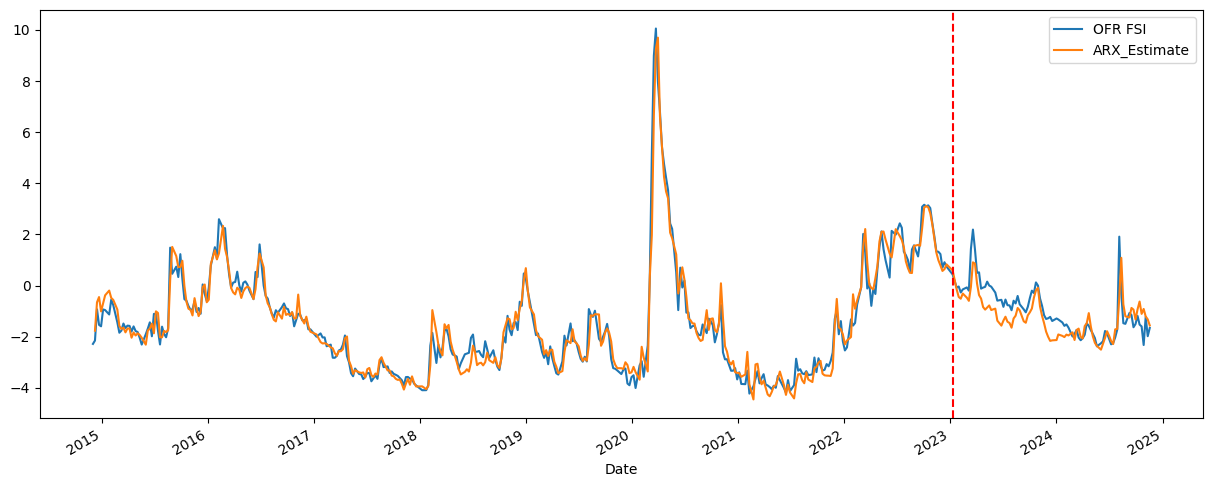

In [62]:
comparison_df[['OFR FSI', 'ARX_Estimate']].plot(figsize = (15,6)).axvline(x="2023-01-09", color='red', linestyle='--')

### MLPRegressor

In [65]:
mlp_model = MLPRegressor(hidden_layer_sizes=(200),  
                         solver='lbfgs', # Solver basically tells us how the weights will change during backpropagation
                         activation='relu',
                         max_iter=1000,    
                         random_state=42)
mlp_model.fit(x_train, y_train)
# Train the model
in_sample_prediction = mlp_model.predict(x_train)
in_sample_prediction = pd.Series([x for x in in_sample_prediction], index = y_train.index)
out_sample_prediction = mlp_model.predict(x_test)
out_sample_prediction = pd.Series([x for x in out_sample_prediction], index = y_test.index)
cor_coef =  np.corrcoef(y_test["OFR FSI"], out_sample_prediction)[0,1] ##correlation coefficient

print("In  sample score R^2  : ", mlp_model.score(x_train, y_train) )
print("Out sample Correlation: ", cor_coef )
print("Out sample MSE        : ", mean_squared_error(y_test, out_sample_prediction) )
comparison_df.loc[:,'MLP_Estimate'] = pd.concat([in_sample_prediction, out_sample_prediction], axis=0)

C:\projects\ams520\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In  sample score R^2  :  0.7189367687413932
Out sample Correlation:  0.7522538329193782
Out sample MSE        :  22710.520975749816


C:\projects\ams520\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\sahil\AppData\Local\Temp\ipykernel_9396\3270407930.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_df.loc[:,'MLP_Estimate'] = pd.concat([in_sample_prediction, out_sample_prediction], axis=0)


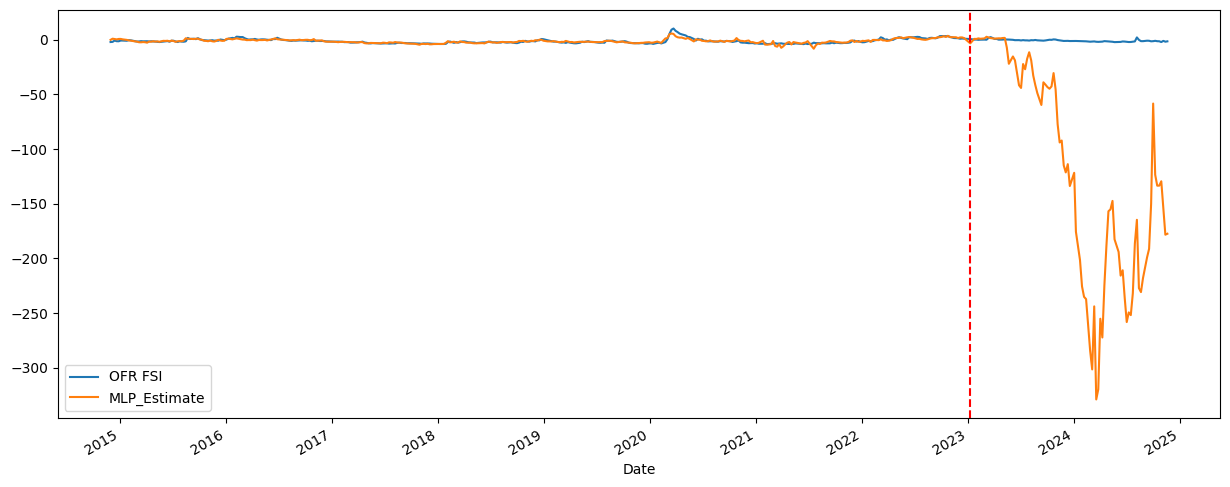

In [67]:
comparison_df[['OFR FSI', 'MLP_Estimate']].plot(figsize = (15,6)).axvline(x="2023-01-09", color='red', linestyle='--')

## Recurrant Neural Network

In [302]:
rnn_model = keras.Sequential([
    layers.Input(shape=(8,)),        
    layers.Dense(1000, activation='relu'),  # Hidden layer with 32 neurons and ReLU activation
    layers.Dense(1)                  # Output layer with a single neuron (for regression)
])

rnn_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_model.fit(x_train, y_train, epochs=300, batch_size=32)

# Train the model
in_sample_prediction = rnn_model.predict(x_train)
in_sample_prediction = pd.Series([x[0] for x in in_sample_prediction], index = y_train.index)
out_sample_prediction = rnn_model.predict(x_test)
out_sample_prediction = pd.Series([x[0] for x in out_sample_prediction], index = y_test.index)
cor_coef =  np.corrcoef(y_test["OFR FSI"], out_sample_prediction)[0,1] ##correlation coefficient

# print("In  sample score R^2  : ", rnn_model.score(x_train, y_train) )
print("Out sample Correlation: ", cor_coef )
print("Out sample MSE        : ", mean_squared_error(y_test, out_sample_prediction) )
comparison_df.loc[:,'RNN_Estimate'] = pd.concat([in_sample_prediction, out_sample_prediction], axis=0)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Out sample Correlation:  -0.740577516081596
Out sample MSE        :  9265.038191029256


C:\Users\sahil\AppData\Local\Temp\ipykernel_18572\2949532365.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='Date'>

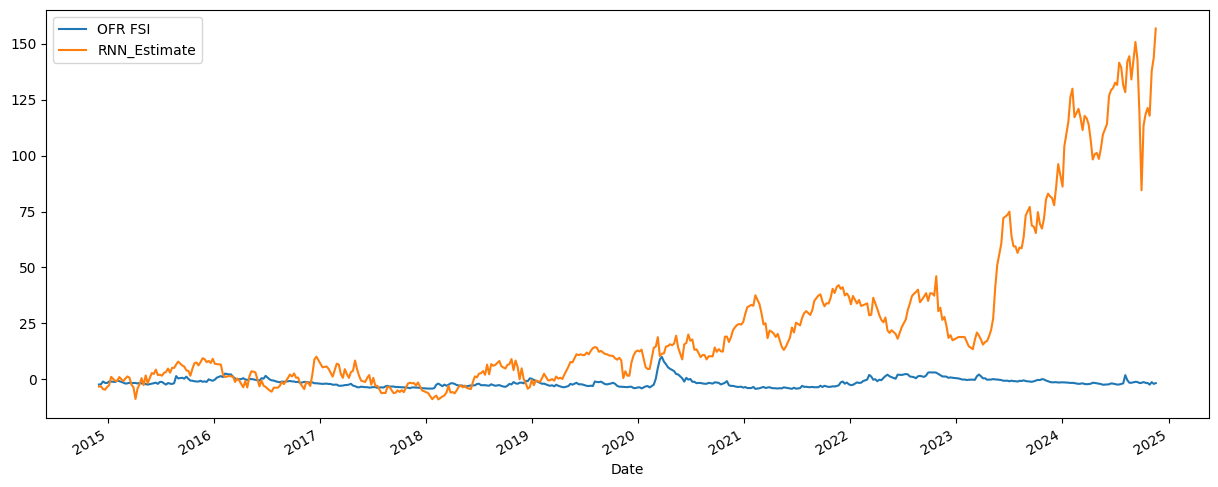

In [303]:
comparison_df[['OFR FSI', 'RNN_Estimate']].plot(figsize = (15,6))

In [ ]:
# Define the model
def build_model(hp):
    model = keras.Sequential()
    
    # Tunable number of neurons in the dense layer
    model.add(layers.Dense(
        units=hp.Int('units', min_value=500, max_value=3000, step=500),  # Tune up to 3000 neurons
        activation='relu',
        input_shape=(8,)  # 8 features as the input dimension
    ))
    
    # Output layer for regression (linear activation)
    model.add(layers.Dense(1, activation='linear'))  # Linear activation for regression
    
    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])  # Tune learning rate
        ),
        loss='mean_squared_error',  # Loss function for regression
        metrics=['mean_absolute_error']  # Regression metric
    )
    return model

# Set up the tuner
tuner = keras_tuner.Hyperband(
    build_model,
    objective='val_mean_absolute_error',  # Objective metric for regression
    max_epochs=300,  # Maximum number of epochs to tune
    factor=3,  # Hyperband reduction factor
    directory='my_dir',
    project_name='tune_neurons_epochs_regression'
)


stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Replace `x_train` and `y_train` with your training data
tuner.search(X, y, validation_split=0.2, callbacks=[stop_early])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Optimal number of neurons: {best_hps.get('units')}")
print(f"Optimal learning rate: {best_hps.get('learning_rate')}")